In [1]:
# Core imports for model training and visualization.
# TensorFlow drives the CNN; matplotlib/seaborn are used to inspect training dynamics.
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Production-grade data pipeline and reproducibility setup.
# This cell replaces earlier ad-hoc dataset loading for new experiments.

import config
from data_pipeline import (
    set_global_seed,
    build_training_dataset,
    build_validation_dataset,
    build_test_dataset,
    build_experiment_run_id,
    save_experiment_artifacts,
)

# Ensure all sources of randomness are controlled (Python, NumPy, TensorFlow, dataset shuffling).
set_global_seed(config.SEED)

# Structured datasets for each split.
train_ds = build_training_dataset()
val_ds   = build_validation_dataset()
test_ds  = build_test_dataset()

Found 70295 files belonging to 38 classes.


2026-01-29 10:06:29.498620: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2026-01-29 10:06:29.498660: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-29 10:06:29.498664: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
I0000 00:00:1769652389.498987 2944392 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1769652389.499305 2944392 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 14059 files belonging to 38 classes.
Found 3513 files belonging to 38 classes.


In [3]:
# CNN model compatible with the structured data pipeline.
# Design: three Conv+MaxPool blocks extract hierarchical visual features,
# followed by a small dense head for 38-way classification.

from tensorflow.keras import layers, models, optimizers

cnn = models.Sequential([
    # Input is fixed at 128x128x3 to match config.IMG_SIZE and the loaders.
    layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=(config.IMG_SIZE[0], config.IMG_SIZE[1], config.NUM_CHANNELS)),
    layers.MaxPool2D(2),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPool2D(2),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPool2D(2),

    # Dropout helps reduce overfitting on visually similar leaf images.
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(config.NUM_CLASSES, activation="softmax"),
])

# Compile with Adam + categorical cross-entropy for multi-class classification.
cnn.compile(
    optimizer=optimizers.Adam(learning_rate=config.LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Optional: inspect the model summary when debugging architecture changes.
# cnn.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Train the model using the new data pipeline and callbacks tuned for stability and performance.

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping stops training when validation loss plateaus, restoring the best weights.
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1,
)

# ReduceLROnPlateau lowers the learning rate when validation loss stalls,
# which often helps push validation accuracy higher.
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1,
)

history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config.EPOCHS,
    callbacks=[early_stopping, lr_scheduler],
)

Epoch 1/20


2026-01-29 10:06:30.187222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 128s 58ms/step - accuracy: 0.3473 - loss: 2.3638 - val_accuracy: 0.5657 - val_loss: 1.6566 - learning_rate: 1.0000e-04
Epoch 2/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 216s 98ms/step - accuracy: 0.5176 - loss: 2.4085 - val_accuracy: 0.5357 - val_loss: 4.5538 - learning_rate: 1.0000e-04
Epoch 3/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4496 - loss: 8.6536
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 252s 114ms/step - accuracy: 0.4496 - loss: 8.6546 - val_accuracy: 0.5148 - val_loss: 12.5817 - learning_rate: 1.0000e-04
Epoch 4/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 221s 100ms/step - accuracy: 0.5245 - loss: 11.7489 - val_accuracy: 0.5583 - val_loss: 12.5001 - learning_rate: 5.0000e-05
Epoch 5/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.4954 - loss: 17.5335
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 242s 110m

In [5]:
# Evaluate on train/validation/test splits and log the experiment for reproducibility.

train_loss, train_acc = cnn.evaluate(train_ds, verbose=0)
val_loss, val_acc     = cnn.evaluate(val_ds, verbose=0)
test_loss, test_acc   = cnn.evaluate(test_ds, verbose=0)

print(f"Training accuracy:   {train_acc:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Testing accuracy:    {test_acc:.4f}")

# Persist history, metrics, and config as a named experiment run.
run_id = build_experiment_run_id(prefix="cnn_pipeline")

train_metrics = {"loss": float(train_loss), "accuracy": float(train_acc)}
val_metrics   = {"loss": float(val_loss),   "accuracy": float(val_acc)}
test_metrics  = {"loss": float(test_loss),  "accuracy": float(test_acc)}

from config import DEFAULT_EXPERIMENT_CONFIG
save_experiment_artifacts(
    run_id=run_id,
    history=history,
    train_metrics=train_metrics,
    val_metrics=val_metrics,
    test_metrics=test_metrics,
    experiment_config=DEFAULT_EXPERIMENT_CONFIG,
)

Training accuracy:   0.5830
Validation accuracy: 0.5657
Testing accuracy:    0.5682


In [6]:
# Training dataset: directory-based loader gives us (image, one-hot label) batches.
# We resize to 128x128 here; normalization and augmentation are handled in the pipeline code.
training_set = tf.keras.utils.image_dataset_from_directory(
    'data/train',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    interpolation="bilinear"
)

Found 70295 files belonging to 38 classes.


In [7]:
# Validation dataset: same class structure and image size as training, but no augmentation.
# Keeping validation preprocessing stable makes it easier to compare experiment runs.
validation_set = tf.keras.utils.image_dataset_from_directory(
    'data/valid',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    interpolation="bilinear"
)

Found 14059 files belonging to 38 classes.


In [8]:
# Core CNN architecture for leaf disease classification.
# Improvements vs earlier version:
# - Explicit input normalization (Rescaling)
# - Built‑in data augmentation layers
# - Batch normalization and larger dense head
# These typically give a solid boost in accuracy on leaf disease datasets.

cnn = tf.keras.models.Sequential()

# Input preprocessing: scale pixels and apply light augmentation during training
cnn.add(tf.keras.layers.Rescaling(1.0 / 255.0, input_shape=[128, 128, 3]))
cnn.add(tf.keras.layers.RandomFlip("horizontal"))
cnn.add(tf.keras.layers.RandomRotation(0.1))
cnn.add(tf.keras.layers.RandomZoom(0.1))

# 1st Convolutional Block: low-level edges / textures
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# 2nd Convolutional Block: mid-level patterns
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# 3rd Convolutional Block: higher-level disease structures
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Dropout + Dense head
cnn.add(tf.keras.layers.Dropout(0.4))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=512, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.4))

# Output Layer: 38‑way softmax for multi‑class disease prediction
cnn.add(tf.keras.layers.Dense(units=38, activation='softmax'))

# Compile the model: slightly higher learning rate + accuracy metric
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Model summary
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,891,366 (64.44 MB)

 Trainable params: 16,890,918 (64.43 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
# Slightly higher patience + more epochs gives the model
# time to benefit from augmentation without overfitting.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with early stopping
training_history = cnn.fit(
    x=training_set,
    validation_data=validation_set,
    epochs=30,
    callbacks=[early_stopping],
)


Epoch 1/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 374s 168ms/step - accuracy: 0.4013 - loss: 20.9529 - val_accuracy: 0.4856 - val_loss: 66.2298
Epoch 2/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 364s 166ms/step - accuracy: 0.7365 - loss: 16.7722 - val_accuracy: 0.7237 - val_loss: 28.5382
Epoch 3/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 349s 159ms/step - accuracy: 0.8177 - loss: 12.6691 - val_accuracy: 0.5523 - val_loss: 87.7710
Epoch 4/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 366s 166ms/step - accuracy: 0.8564 - loss: 10.2046 - val_accuracy: 0.8617 - val_loss: 10.5215
Epoch 5/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 408s 186ms/step - accuracy: 0.8741 - loss: 9.0160 - val_accuracy: 0.7793 - val_loss: 23.7565
Epoch 6/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 431s 196ms/step - accuracy: 0.8890 - loss: 8.1469 - val_accuracy: 0.7014 - val_loss: 56.5429
Epoch 7/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 443s 202ms/step - accuracy: 0.8990 - loss: 7.5031 - val_accuracy: 0.8932 - val_loss: 9.2361
Epoch 8/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 451s 205ms

In [11]:
#Training set Accuracy
train_loss, train_acc = cnn.evaluate(training_set)
print('Training accuracy:', train_acc)

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 55s 25ms/step - accuracy: 0.9530 - loss: 5.8452
Training accuracy: 0.9541930556297302


In [12]:
#Validation set Accuracy
val_loss, val_acc = cnn.evaluate(validation_set)
print('Validation accuracy:', val_acc)

440/440 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9466 - loss: 7.4544
Validation accuracy: 0.9474357962608337


In [13]:
# Save the trained model in .h5 format
cnn.save('trained_plant_disease_model.h5')

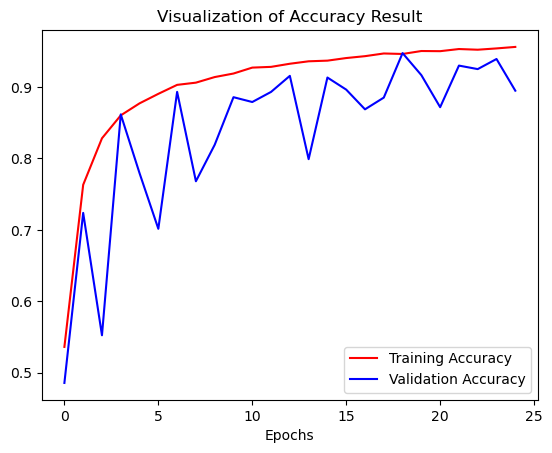

In [14]:
# Plotting accuracy
plt.plot(training_history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [15]:
# Prepare test set
test_set = tf.keras.utils.image_dataset_from_directory(
    'data/test',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False,
    interpolation="bilinear"
)

Found 3513 files belonging to 38 classes.


In [16]:
# Make predictions
y_pred = cnn.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)

# Get true categories
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)

test_loss, test_acc = cnn.evaluate(test_set)
print('Testing accuracy:', test_acc)

3513/3513 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step


2026-01-29 13:06:38.743907: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3513/3513 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9600 - loss: 5.0663
Testing accuracy: 0.9473384618759155


In [17]:
# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(Y_true, predicted_categories)



In [18]:
# Precision Recall Fscore
print(classification_report(Y_true, predicted_categories, target_names=test_set.class_names))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.86      0.93       101
                                 Apple___Black_rot       0.84      1.00      0.91        99
                          Apple___Cedar_apple_rust       0.99      1.00      0.99        88
                                   Apple___healthy       0.93      0.99      0.96       100
                               Blueberry___healthy       0.97      0.93      0.95        91
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      0.99        84
                 Cherry_(including_sour)___healthy       0.96      0.99      0.97        91
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      1.00      0.98        82
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00        95
               Corn_(maize)___Northern_Leaf_Blight       1.00      0.92      0.

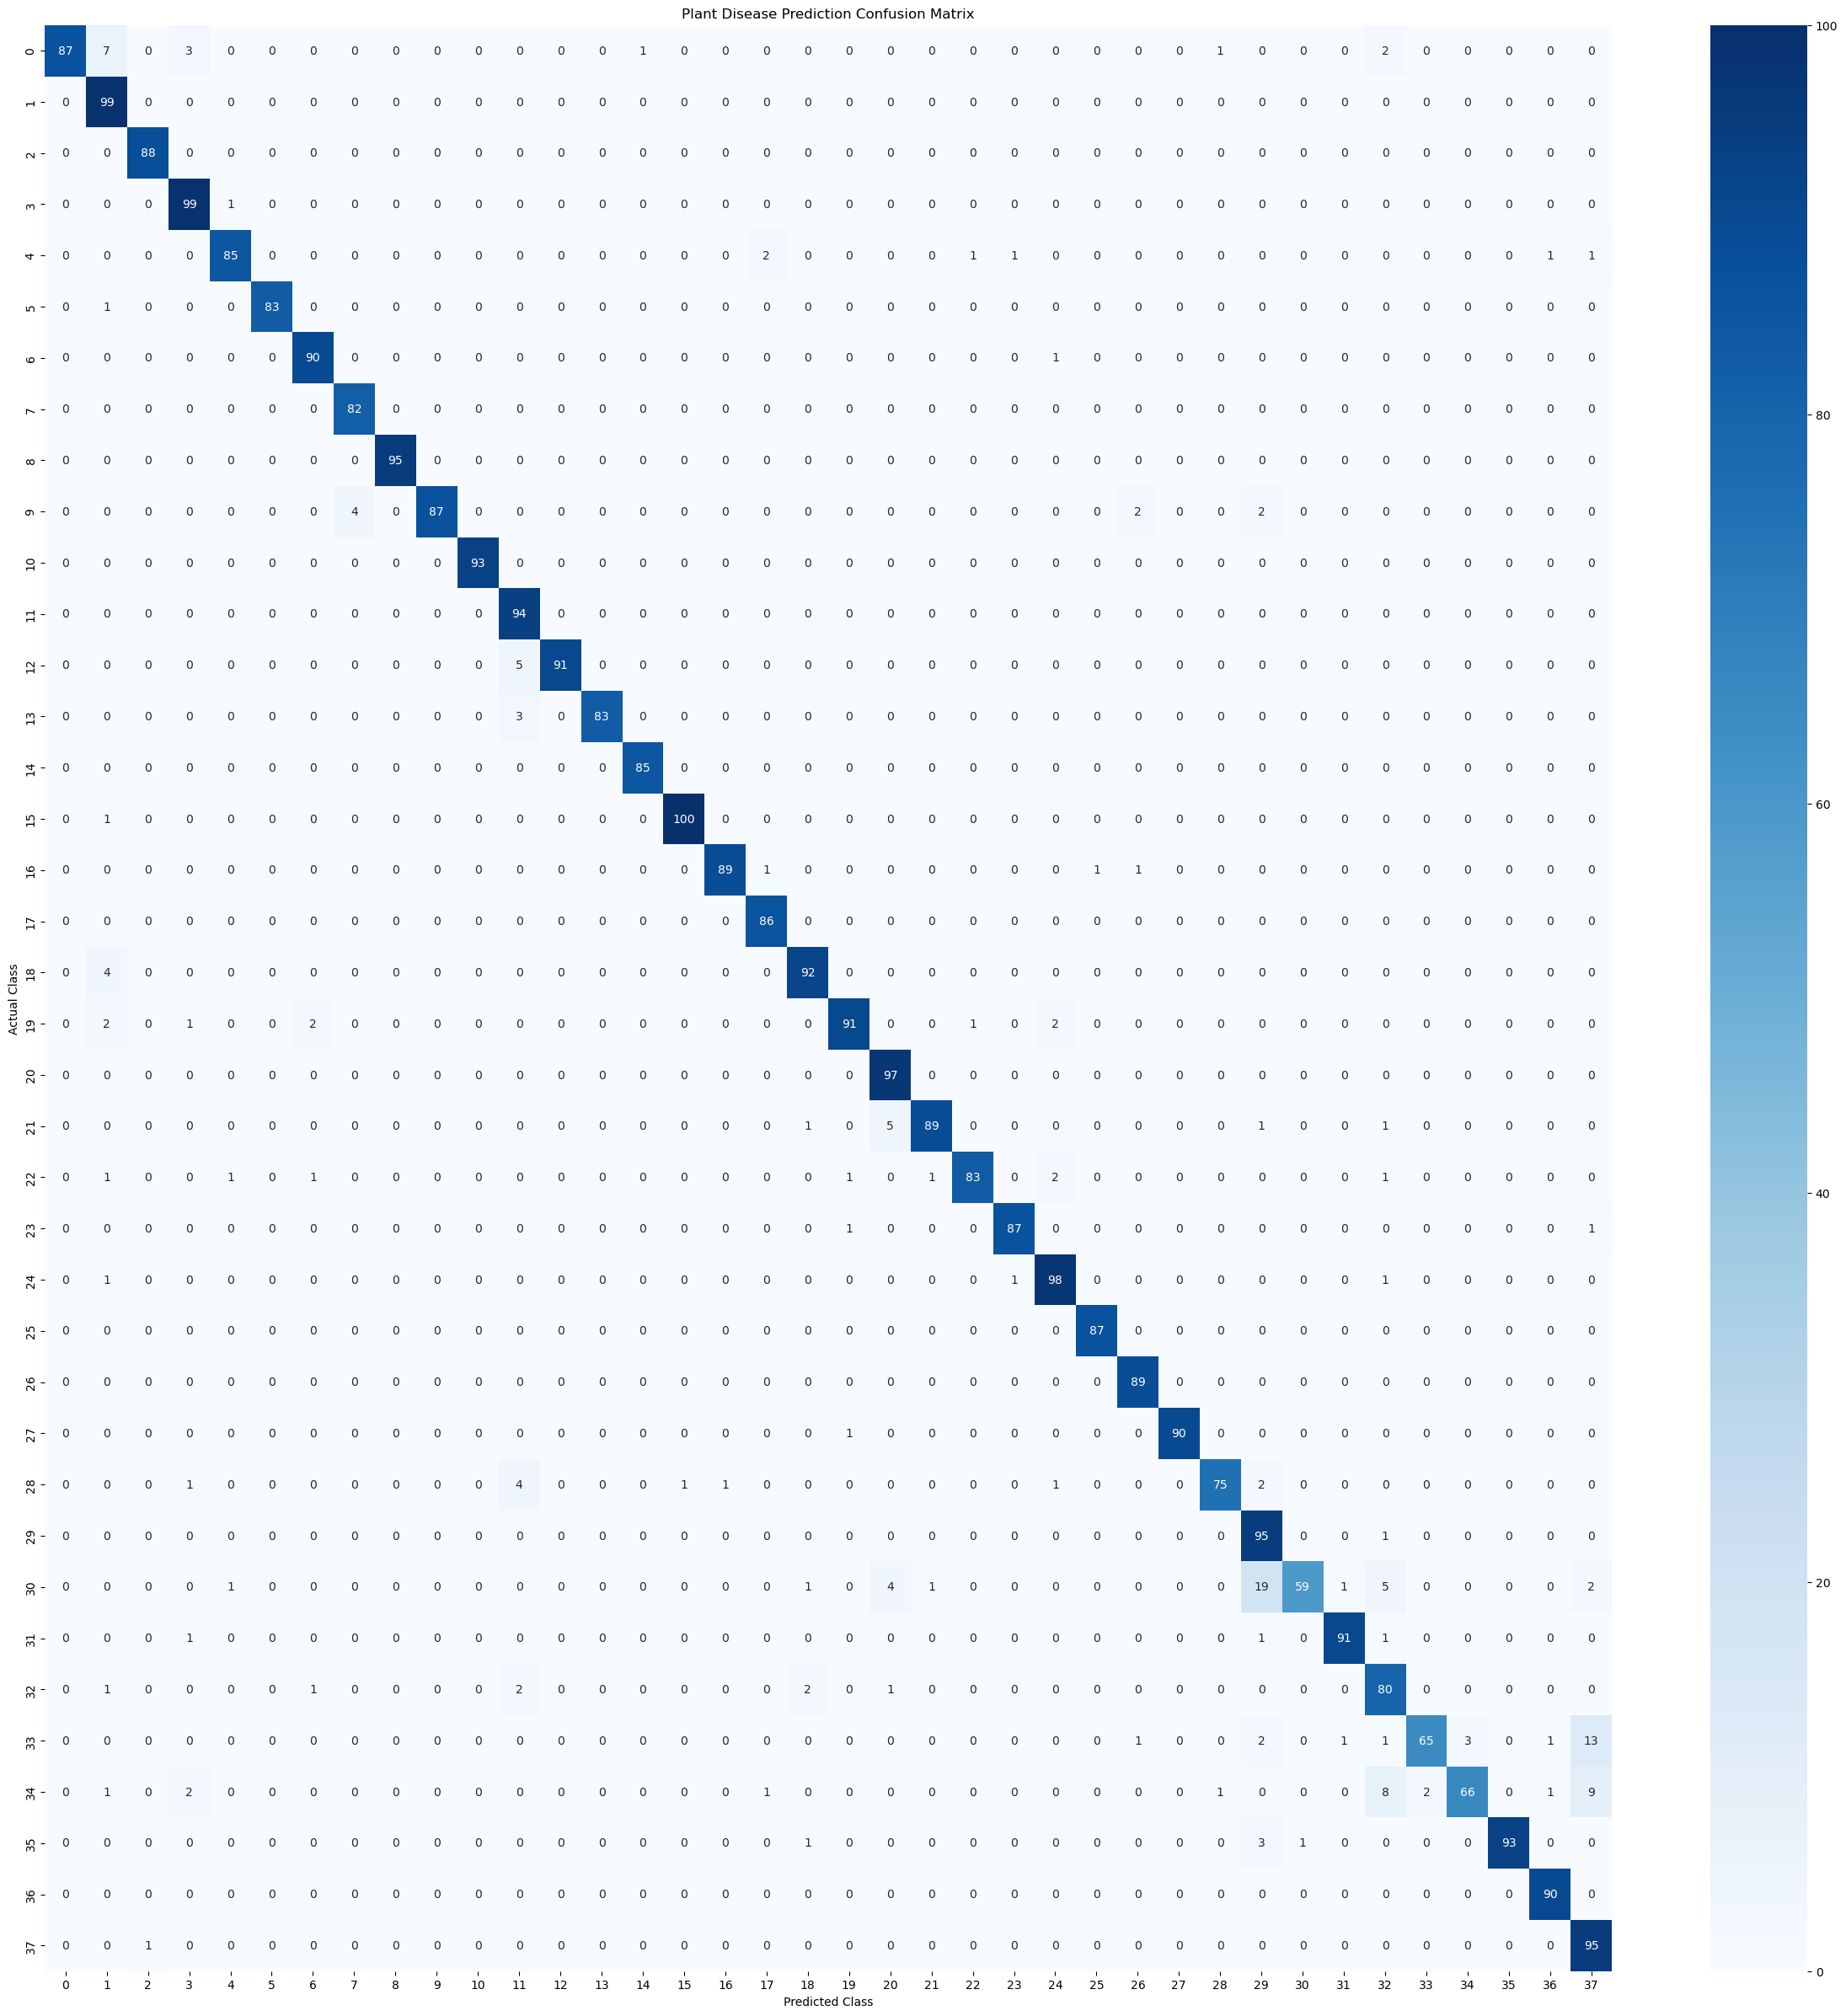

In [19]:
# Plot confusion matrix
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Plant Disease Prediction Confusion Matrix')
plt.show()